# Lyapunov

In [1]:
import numpy as np
import queue
import ipdb
import matplotlib.pyplot as plt
import pickle
import sympy as sp
import random as rand
import os
from scipy import optimize
import itertools as it

In [2]:
def saveData(dataX, dataY, xlab, ylab, exp):
    cwd = os.getcwd()
    
    xfileName = str(exp)+'_'+ xlab + '.pckl'
    f = open(os.path.join(cwd, 'Data', xfileName), 'wb')
    print(xfileName)
    pickle.dump(dataX, f)
    f.close()
    
    yfileName = str(exp)+'_'+ylab + '.pckl'
    f = open(os.path.join(cwd, 'Data', yfileName), 'wb')
    print(yfileName)
    pickle.dump(dataY, f)
    f.close()
    
def loadData(xlab, ylab, exp):
    
    cwd = os.getcwd()
    
    xfileName = str(exp)+'_'+ xlab + '.pckl'
    f = open(os.path.join(cwd, 'Data', xfileName), 'rb')
    xData = pickle.load(f)
    f.close()
     
    yfileName = str(exp)+'_'+ylab + '.pckl'
    f = open(os.path.join(cwd, 'Data', yfileName), 'rb')
    yData = pickle.load(f)
    f.close()
    
    return xData, yData

In [3]:
class Packet(object):
    
    def __init__(self, queueNum, arrivalTime):
        global MESID
    
        try:
            MESID +=1
        except NameError:
            MESID = 0    
    
        self.pid = MESID
        self.queueNum = queueNum
        self.arrivalTime = arrivalTime
        self.isSent = False
        self.sentTime = -1
        
    def __repr__(self):
        return str([self.pid, self.queueNum, self.arrivalTime, self.sentTime, self.delayTime])
        
    def __str__(self):
        return str([self.pid, self.queueNum, self.arrivalTime, self.sentTime, self.delayTime])
    
    def send(self, sentTime):
        self.isSent = True
        self.sentTime = sentTime
        self.delayTime = self.sentTime - self.arrivalTime
        
        return self
    
    @staticmethod
    def resetIDs():
        global MESID
        MESID=-1

In [4]:
def getS(probs):
    return np.random.choice(len(probs), p=probs)
    
def getA(l):
    #return np.random.poisson(l)
    return np.random.binomial(1,l)

def getLmdas(flmdas, numPoints):
    return list(map(list, zip(*[list(np.linspace(0, flmdas[0], num=numPoints)), list(np.linspace(0, flmdas[1], num=numPoints))])))

def lyapunov(lmda, Sp, finalT):
    # initialize queues
    NUMQ = len(lmda)
    Q = [queue.Queue()]*NUMQ
    Packet.resetIDs()
    sentPackets = []
    Backlogs = []

    for t in np.arange(finalT):
        
        St = [getS(Sp[i]) for i in np.arange(NUMQ)]
        Qt = [q.qsize() for q in Q]

        Backlogs.append(Qt)
    
        maxW = [q*s for q,s in zip(Qt,St)]
    
        alpha = maxW.index(max(maxW))
    
        # Send packets
        for pNum in np.arange(St[alpha]):
        
            if Q[alpha].empty():
                break
        
            packet = Q[alpha].get()
            sentPackets.append(packet.send(t))
            
        # Packets arrive
        for i in np.arange(NUMQ):
            for packet in np.arange(getA(lmda[i])):
                Q[i].put(Packet(i, t))
    
    return Backlogs

In [9]:
def getOptimizationParams(numq, nums):
    Cub = [0]*(1+ numq*nums)
    Cub[0] = -1
    
    return Cub

def getOptimizationMatrix(numq, sstates, sprobs):
    nums = np.prod([len(probs) for probs in sprobs]) 
    Aub = np.zeros((numq+nums, 1+nums*numq))
        
    states = list(it.product(*sstates))
    probs = list(it.product(*sprobs))
    
    for channel in np.arange(numq):
        Aub[channel, 0] = 1
        for i in np.arange(len(states)):
            Aub[channel, 1+nums*channel+i] = -states[i][channel]*np.product([probs[i]])

        
    for state in np.arange(nums):
        for q in np.arange(numq):
            Aub[numq + state, 1+q*nums+state] = 1
        
    return [list(r) for r in Aub]

def getOptimizationBounds(numq,nums, lmdas):
    
    Bub = np.ones((1,numq+nums))[0]
    Bub[0:numq] = [-l for l in lmdas]
    
    return list(Bub)

LinearProgramMappings = {}

def getEpsilonMax(sstates, sprobs, lmdas):
    
    numq = len(lmdas)
    nums = np.prod([len(probs) for probs in sprobs]) 

    HASHKEY = str([sstates, sprobs])

    if HASHKEY in LinearProgramMappings and "Cub" in LinearProgramMappings[HASHKEY]:
        Cub = LinearProgramMappings[HASHKEY]["Cub"]
        Aub = LinearProgramMappings[HASHKEY]["Aub"]
    
    else:
        Cub = getOptimizationParams(numq, nums)
        Aub = getOptimizationMatrix(numq, sstates, sprobs)
        
        LinearProgramMappings[HASHKEY] = {"Cub": Cub, "Aub": Aub}
        
    Bub = getOptimizationBounds(numq,nums, lmdas)
    
    return optimize.linprog(
        c = Cub, 
        A_ub= Aub, 
        b_ub=Bub,
        method='simplex'
    )["x"][0]


def getB(sstates, sprobs, lmdas):

    HASHKEY = str([sstates, sprobs])
    
    if HASHKEY in LinearProgramMappings:
        if "B" in LinearProgramMappings[HASHKEY]:
            return LinearProgramMappings[HASHKEY]["B"]
    
    
    numq = len(lmdas)
        
    EA = sum(lmdas)
    EB = sum([max([a**2*b for a, b in zip(sstates[i], sprobs[i])]) for i in np.arange(numq)])
        
    B = 0.5*(EA+EB)
        
    LinearProgramMappings[HASHKEY] = {"B": B}
    
    return B

## Simulate

In [22]:
Z = [0.372, 0.868]
Sprobs = [[0.3, 0.7], [0.2, 0.5, 0.3]]
Sstates = [[0, 1], [0, 1, 2]]
num = 10000
fT = 10000 #10**6
avgBacklogs = []
theoBacklogs = []

if False:
    for lmdas in getLmdas(Z, num):
        backlogs = lyapunov(lmdas, Sprobs, fT)
        avgBacklogs.append(np.mean([sum(backlog) for backlog in backlogs]))

    saveData(np.linspace(0, 1, num), avgBacklogs, 'rho', 'avgTotalBacklog', 'Fig3.2')    

if True:
    for lmdas in getLmdas(Z, num):
        B = getB(Sstates, Sprobs, lmdas)
        epsmax = getEpsilonMax(Sstates, Sprobs, lmdas)
        theoBacklogs.append(B/epsmax)
        
    saveData(np.linspace(0, 1, num), theoBacklogs, 'rho', 'theoTotalBacklog', 'Fig3.2')  

Fig3.2_rho.pckl
Fig3.2_theoTotalBacklog.pckl


## Plot

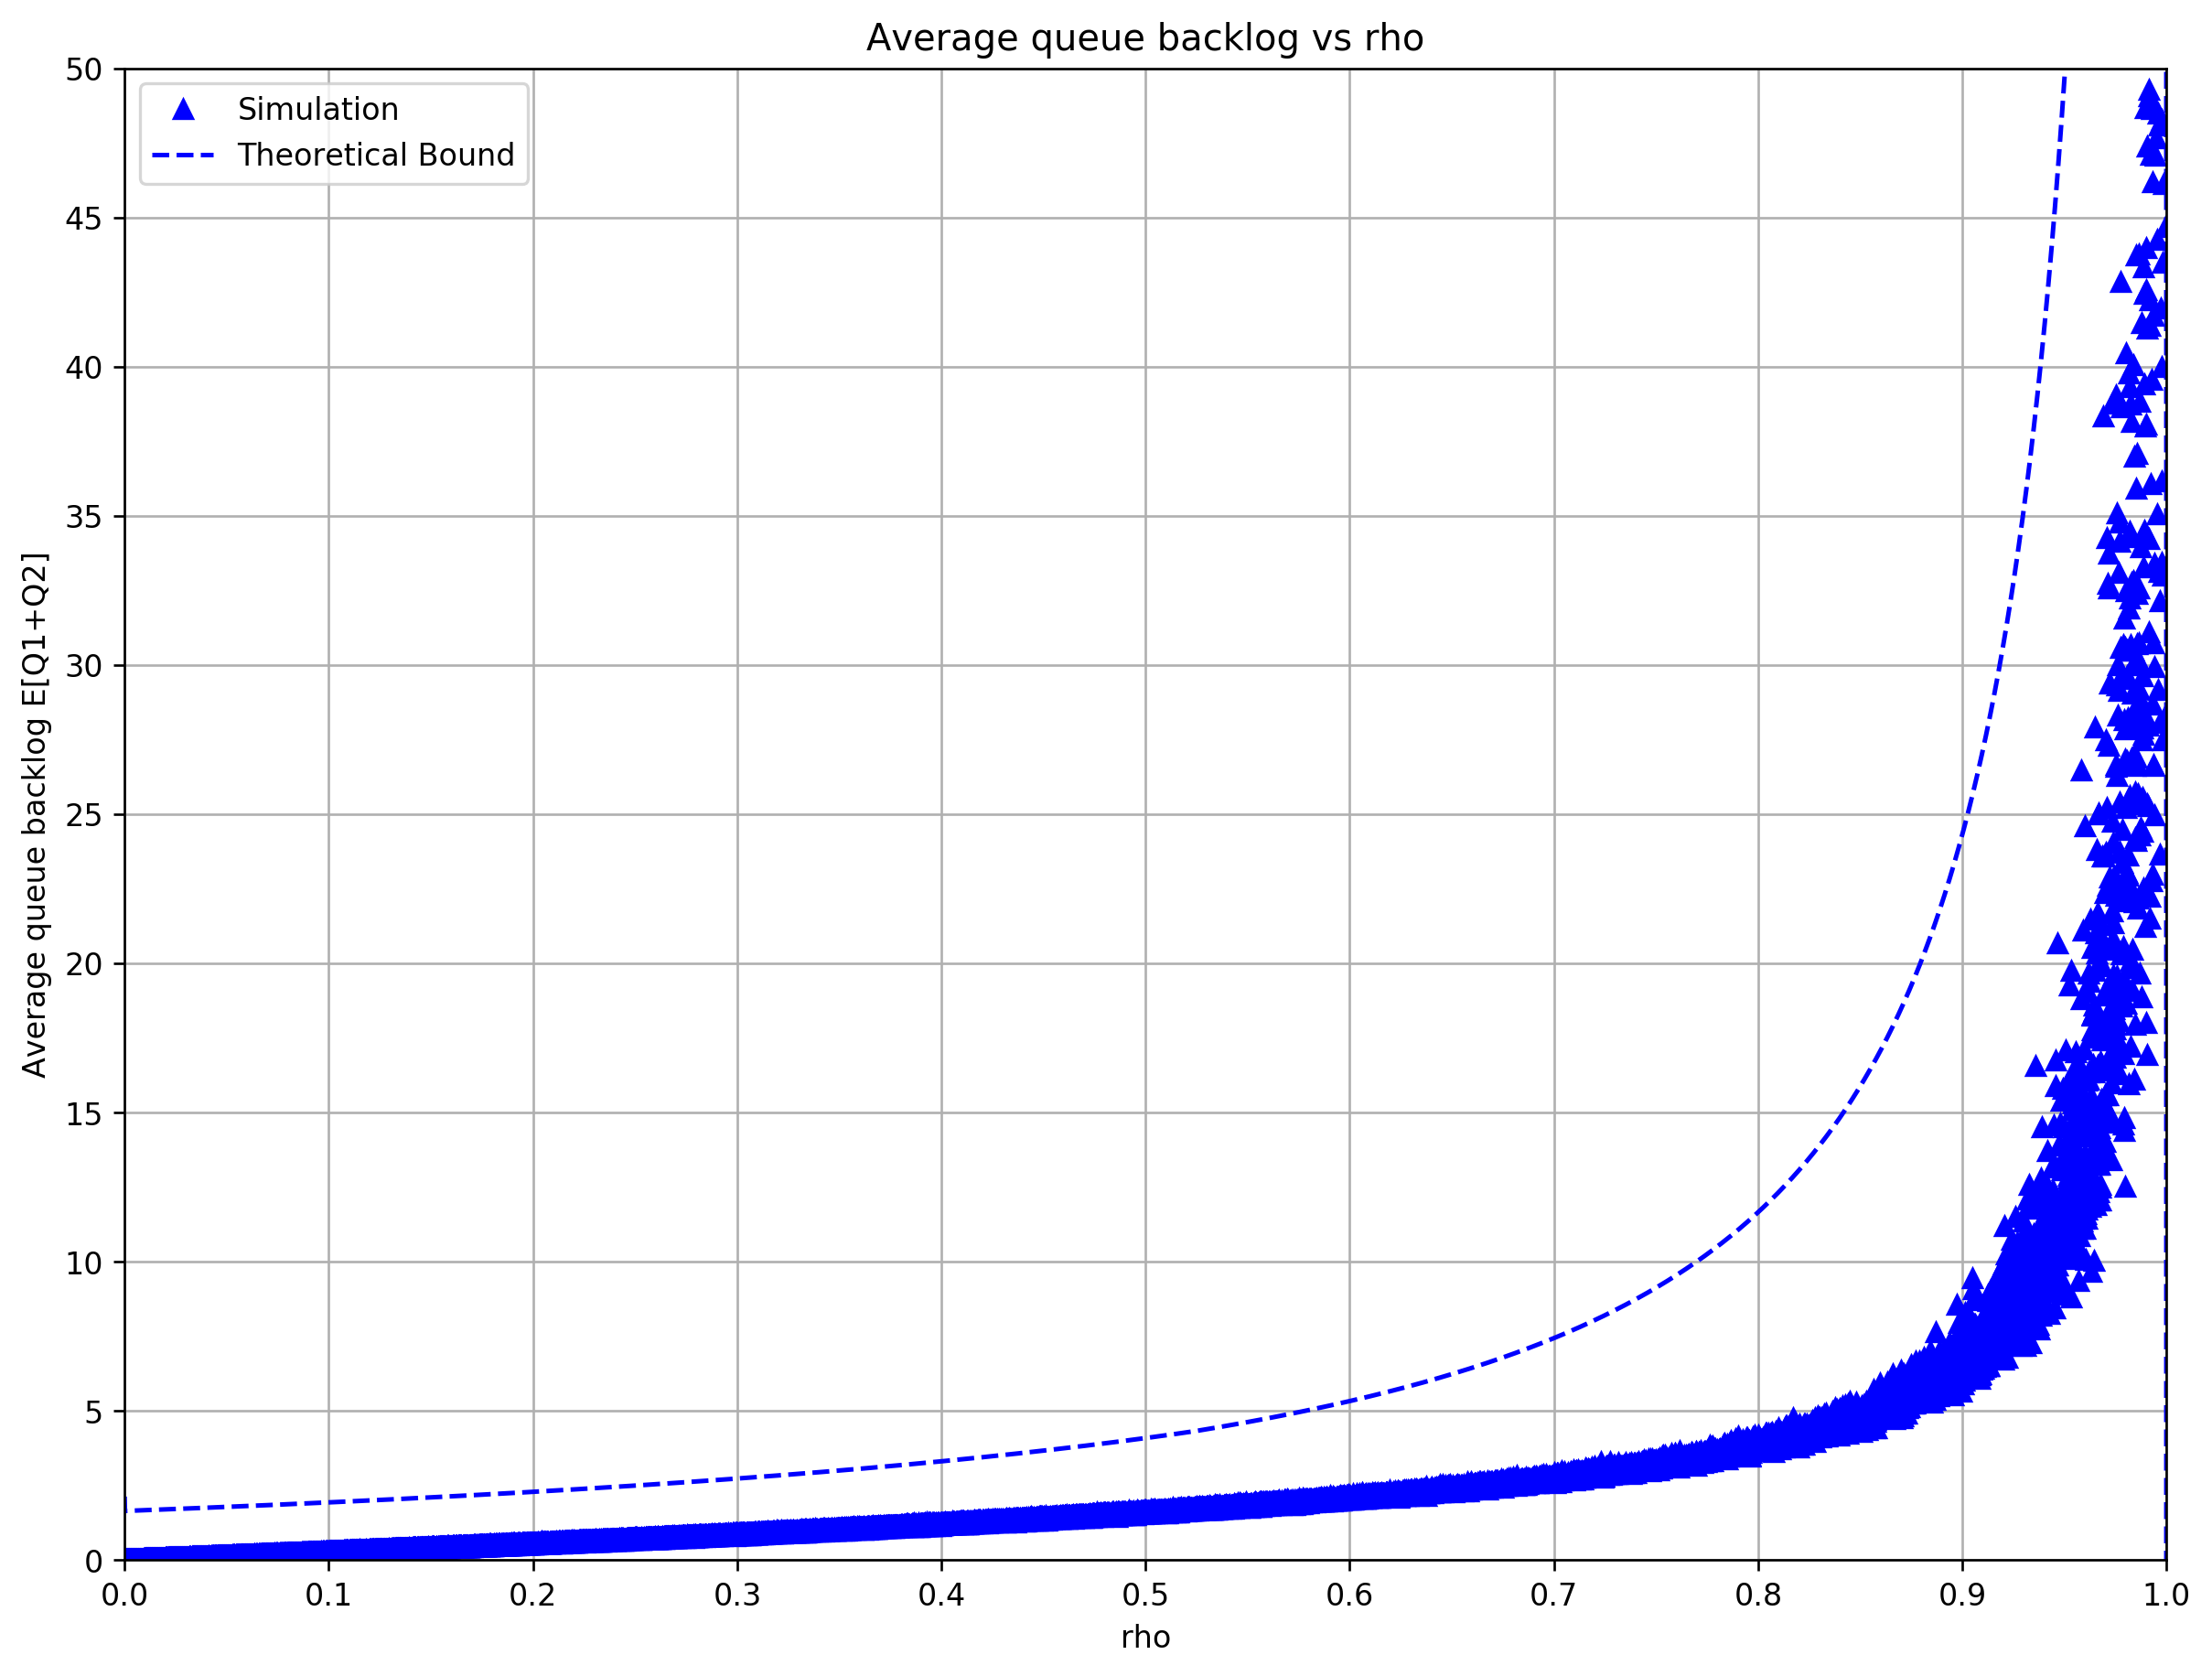

In [23]:
fig = plt.figure(num=None, figsize=(12, 9), dpi=240, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.grid(True)

x, y = loadData('rho', 'avgTotalBacklog', 'Fig3.2')
plt.plot(x, y, 'b^')
x, y = loadData('rho', 'theoTotalBacklog', 'Fig3.2')
plt.plot(x, y, 'b--')


plt.title('Average queue backlog vs rho')
plt.xlabel('rho')
plt.ylabel('Average queue backlog E[Q1+Q2]')
plt.axis([0, 1, 0, 50])
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 55, 5))

plt.legend(["Simulation", "Theoretical Bound"])
plt.show()